In [152]:
from tkinter import *
from tkinter import ttk, filedialog
from tkinter.filedialog import askopenfilename
import csv
from pathlib import Path
import pymongo
import numpy as np
# Use sentinel for missing values
from numpy import nan as NA
import pandas as pd
# For showing plots in tkinter
import matplotlib.pyplot as plt
from matplotlib.figure import Figure 
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg,  
NavigationToolbar2Tk) 
import seaborn as sns
import tkinter.constants as Tkconstants

# connect to mongodb
client = pymongo.MongoClient("mongodb://localhost:27017")
# create db
db_formative = client["summative"]
# create collection
collection_vendors = db_formative["test-422"]

In [153]:
class Parser(object):
    def __init__(self, csvFile):
        self.csvFile = csvFile
        
    def parseData(self):
        # Read CSV files and convert to Pandas DataFrames
        inspectionsDF = pd.read_csv(self.csvFile['inspections'], usecols=['ACTIVITY DATE', 'FACILITY ID', 'FACILITY NAME', 'PROGRAM STATUS', 'PE DESCRIPTION', 'FACILITY ZIP', 'SERIAL NUMBER', 'SCORE'])
        inventoryDF = pd.read_csv(self.csvFile['inventory'])
        violationsDF = pd.read_csv(self.csvFile['violations'], usecols=['SERIAL NUMBER', 'VIOLATION CODE'])
        
        return inspectionsDF, inventoryDF, violationsDF
                

In [154]:
class DataCleaner(object):
    def __init__(self, inspections, inventory, violations):
        self.inspectionsDF = inspections
        self.inventoryDF = inventory
        self.violationsDF = violations
        
    def clean(self):
        print('cleaning')
        self.cleanInspections()
        self.removeAnomalies()
        return self.inspectionsDF, self.inventoryDF, self.violationsDF
        
    def cleanInspections(self):
        # Extract info from PE DESC column and create new col for SEATING DETAILS
        self.inspectionsDF['SEATING DETAILS'] = self.inspectionsDF['PE DESCRIPTION'].str.extract(r"\(([\S ]+)\)")
        print(f'seating deats \n{self.inspectionsDF["SEATING DETAILS"]}')
        print(f'pe desc \n{self.inspectionsDF["PE DESCRIPTION"]}')
        # Extract first part of Zip Code (e.g. '90001-1234', becomes '90001')
        self.inspectionsDF['FACILITY ZIP'] = self.inspectionsDF['FACILITY ZIP'].str.extract(r"([0-9]+)") 
        # Add '_id' for MongoDB      
        self.inspectionsDF['_id'] = 'INS_' + self.inspectionsDF['SERIAL NUMBER']
        
    def removeAnomalies(self):
        # Remove anomalies from SCORES column
        # Print description of data: show quartiles, mean, standard deviation
        print(f'Describe scores data: \n{self.inspectionsDF["SCORE"].describe()}')
        # Print box plot to show outliers
        fig1, ax1 = plt.subplots()
        data = self.inspectionsDF['SCORE'].dropna()
        ax1.boxplot(data)
        plt.show()
        # Find lower bound (over 3 standard deviations away)
        scoreMean = self.inspectionsDF['SCORE'].mean()
        scoreStd = self.inspectionsDF['SCORE'].std()
        lowerBound = scoreMean-(scoreStd*3)
        # Remove rows where score is lower than lower bound 
        self.inspectionsDF = self.inspectionsDF.drop(self.inspectionsDF[self.inspectionsDF.SCORE < lowerBound].index)
        print(f'Describe scores data ANOMALIES REMOVED: \n{self.inspectionsDF["SCORE"].describe()}')
        # Print box plot to show removal of outliers
        fig2, ax2 = plt.subplots()
        data = self.inspectionsDF['SCORE'].dropna()
        ax2.boxplot(data)
        plt.show()
       

In [155]:
class DataLoader(object):
    def __init__(self, inspections, inventory, violations):
        self.inspectionsDF = inspections
        self.inventoryDF = inventory
        self.violationsDF = violations
        
    def loadToMongo(self):
        # use to_dict to format correctly for MongoDB
        inspectionsDict = self.inspectionsDF.to_dict(orient='records')
        inventoryDict = self.inventoryDF.to_dict(orient='records')
        violationsDict = self.violationsDF.to_dict(orient='records')
        # Insert into Mongo
        collection_vendors.insert_many(inspectionsDict)
    #   collection_vendors.insert_many(inventoryDict)
        collection_vendors.insert_many(violationsDict)
        # Test db
        test = collection_vendors.find({'_id':{'$regex':'INS_'}})
        for t in test:
            print(f'testing inspections: \n{t}')
            break
        print('inserted into Mongo')
     
           

In [156]:
class ButtonUpload(object):
    def __init__(self, fileButtons, fileLabels, counter, mainframe, fileRoutes):
        self.fileButtons = fileButtons
        self.fileLabels = fileLabels
        self.counter = counter
        self.mainframe = mainframe
        self.fileRoutes = fileRoutes
        self.filePath = ''
        self.uploadLabel = StringVar()

    def browseFile(self):
        self.filePath = askopenfilename(filetypes=[("CSV files", ".csv")])
        fileName = Path(self.filePath)
        self.uploadLabel.set(fileName.name)
        print(self.filePath)
        self.setFileRoutes()
    
    def setFileRoutes(self):
        self.fileRoutes[self.fileButtons] = self.filePath
        print(self.fileRoutes)
        
    def createButton(self):
        ttk.Label(self.mainframe, text=f"Upload data: {self.fileButtons}", anchor="w").grid(row=self.counter+1, column=0, sticky="w")
        Button(self.mainframe, text="Upload file", command=self.browseFile).grid(row=self.counter+1, column=1, sticky="w")
        ttk.Label(self.mainframe, textvariable=self.uploadLabel).grid(row=self.counter+1, column=2, sticky="w") 
        

In [157]:
class AveragesCalculator(object):
    def __init__(self, year, category):
        self.year = year
        self.category = category
        
    def zipScores(self):
        print(f'Calculating stats for: \n- Year = {self.year} \n- Category = {self.category}')
        # Find inspection documents - look in inspections (INS_) with year
        resultsInspections = collection_vendors.find({'_id':{'$regex':'INS_'},'ACTIVITY DATE':{'$regex':self.year}, 'PROGRAM STATUS': 'ACTIVE'})

        # Create dict of facility zips with lists of their scores
        zipScoresDict = {}  
        for r in resultsInspections:
            key = r[self.category]
            if key in zipScoresDict:
                zipScoresDict[r[self.category]].append(r['SCORE'])
            else:
                zipScoresDict[key] = [r['SCORE']]
        return self.calcZipStats(zipScoresDict)


    def calcZipStats(self, zipScoresDict):
        zipScoresMean = {}
        zipScoresMean = {self.category:[],'mean':[],'median':[],'mode':[]}
        for x in zipScoresDict:
            # Create Series to calc mean, mode, median
            tempSeries = pd.Series(zipScoresDict[x])
            mean = tempSeries.mean()
            mode = tempSeries.mode().tolist()
            median = tempSeries.median()

            # mean, mode, median as columns
            zipScoresMean[self.category].append(x)
            zipScoresMean['mean'].append(mean)
            zipScoresMean['median'].append(median)
            zipScoresMean['mode'].append(mode)

        # Create DataFrame
        zipScoresDF = pd.DataFrame(zipScoresMean)
        # sort by ascending cat - easier to find for user (esp. zip)
        zipScoresDF.sort_values(by=[self.category],inplace=True)
        # set cat as index
        zipScores_noIndex = zipScoresDF.set_index(self.category)
        
        return zipScores_noIndex
 

In [158]:
class ViolationsPlot(object):
    def __init__(self, tab):
        self.tab = tab
        
    def processData(self):
        # Aggregate inspections and violations using SERIAL NUMBER as ID
        violationsAgg = collection_vendors.aggregate([
            {'$group': {'_id': '$SERIAL NUMBER','PROGRAM STATUS':{'$addToSet':'$PROGRAM STATUS'}, 'FACILITY ID': {'$addToSet': '$FACILITY ID'}, 'VIOLATIONS': {'$addToSet': '$VIOLATION CODE'}}}
        ])
        # Find out what violations were committed by each facility
        # Use a set() to get unique entries 
        # (violations may be committed multiple times by same facility but I only want to count that facility once)
        facilityViolations = {}
        for item in violationsAgg:
            try:
                if item['PROGRAM STATUS'][0] == 'INACTIVE':
                    continue
            except IndexError:
                pass
            except Exception as e:
                print(f'Unexpected error: {e}')
            try:
                if item['FACILITY ID'][0] in facilityViolations:
                    facilityViolations[item['FACILITY ID'][0]].update(item['VIOLATIONS'])
                else:
                    facilityViolations[item['FACILITY ID'][0]] = set()
                    facilityViolations[item['FACILITY ID'][0]].update(item['VIOLATIONS'])
            # Possible error - some violations have serial numbers that are not recorded in Inspections data.
            # These are not used in plots because they do not correspond to a facility.
            except IndexError:
                pass
            except Exception as e:
                print(f'Unexpected error: {e}')

        uniqueVCodes = {}
        for facility in facilityViolations:
            for vCode in facilityViolations[facility]:
                if vCode in uniqueVCodes:
                    uniqueVCodes[vCode] = uniqueVCodes[vCode] + 1
                else:
                    uniqueVCodes[vCode] = 1 
                    
        # Convert data to DataFrame and sort the data descending by value
        data = {'keys':list(uniqueVCodes.keys()), 'values':list(uniqueVCodes.values())}
        uniqueVCodesDF = pd.DataFrame(data)
        uniqueVCodesDF.sort_values(by='values',ascending=False,inplace=True)
        print(uniqueVCodesDF)
        self.createPlot(uniqueVCodesDF)
    
    def createPlot(self, uniqueVCodesDF):
        # Display violations vs no. of establishments
        vioKeys = uniqueVCodesDF['keys']
        vioVals = uniqueVCodesDF['values']
        # Create 4 subplots using slices of the keys & values lists
        fig,a =  plt.subplots(2,2)
        a[0][0].bar(vioKeys[:round(len(vioKeys)*0.25)], vioVals[:round(len(vioKeys)*0.25)])
        a[0][1].bar(vioKeys[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)], vioVals[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)])
        a[1][0].bar(vioKeys[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)], vioVals[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)])
        a[1][1].bar(vioKeys[round(len(vioKeys)*0.75):], vioVals[round(len(vioKeys)*0.75):])
        # Tidy plot - rotate labels & apply layout
        a[0][0].tick_params(axis='x',labelrotation=45)
        a[0][1].tick_params(axis='x',labelrotation=45)
        a[1][0].tick_params(axis='x',labelrotation=45)
        a[1][1].tick_params(axis='x',labelrotation=45)
        plt.tight_layout()
        # Show in console as well as window
        plt.show()
        # creating the Tkinter canvas containing the Matplotlib figure 
        canvas = FigureCanvasTkAgg(fig, master = self.tab)   
        canvas.draw() 
        # grid the canvas on the Tkinter window 
        canvas.get_tk_widget().place(relheight=1, relwidth=1) 


In [159]:
class CorrelationsPlot(object):
    def __init__(self, title):
        self.title = title
        
    def processData(self):
        # Aggregate inspections and violations using SERIAL NUMBER as ID
        violationsZipAgg = collection_vendors.aggregate([
            {'$group': {'_id': '$SERIAL NUMBER','PROGRAM STATUS':{'$addToSet':'$PROGRAM STATUS'},'ZIP': {'$addToSet':'$FACILITY ZIP'}, 'VIOLATIONS': {'$addToSet': '$VIOLATION CODE'}}}
        ])
        # Create dict with {zip code: [violations no. per facility]}
        vioDict = {}
        for item in violationsZipAgg:
            try:
                if item['PROGRAM STATUS'][0] == 'INACTIVE':
                    continue
            except IndexError:
                pass
            except Exception as e:
                print(f'Unexpected error: {e}')
            try:
                zipCode = item['ZIP'][0] + ' -'
                if zipCode in vioDict:
                    vioDict[zipCode].append(len(item['VIOLATIONS']))
                else:
                    vioDict[zipCode] = [len(item['VIOLATIONS'])]
            # Possible error - some violations have serial numbers that are not recorded in Inspections data.
            # These are not used in plots because they do not correspond to a facility.
            except IndexError:
                pass
            except Exception as e:
                print(f'Unexpected error: {e}')

        # Calc mean for violation no.
        for v in vioDict:
            tempSeries = pd.Series(vioDict[v])
            mean = tempSeries.mean()
            vioDict[v] = mean
            
        #  Create DataFrame - sorted by zip to make visualisations easier to understand
        data = {
            'quantity': list(vioDict.values()),
            'zip': list(vioDict.keys())
        }
        insViosDF = pd.DataFrame(data)
        insViosDF.sort_values(by=['quantity'],ascending=False,inplace=True)
        print(insViosDF)
        self.createPlot(insViosDF)
        self.correlationsCalc(insViosDF)
        
    def correlationsCalc(self, insViosDF):
        # Cast string 'zip' to int
        insViosDF['zip'] = insViosDF['zip'].str.replace(' -', '')
        insViosDF['zip'] = insViosDF['zip'].apply(int)
        # Use corr() function to find Pearson correlation
        correlation = insViosDF['quantity'].corr(insViosDF['zip'])
        print(f'====> Pearson correlation between number of violations per vendor and their zip code: \n {correlation}')
        
    
    def createPlot(self, insViosDF):
        # New window
        window = Tk()
        window.title(self.title)
        window.geometry("1200x800")
        window.columnconfigure(0, weight=1)
        window.rowconfigure(0, weight=1)
        
        # Scroll Y
        frame=Frame(window)
        frame.grid(row=0,column=0)
        frame.columnconfigure(0, weight=1)
        frame.rowconfigure(0, weight=1)
        canvas = Canvas(frame)
        canvas.grid(row=0, column=0)
        yScrollbar = Scrollbar(frame)
        yScrollbar.grid(row=0, column=1, sticky=Tkconstants.NS)
        canvas.config(yscrollcommand=yScrollbar.set)
        yScrollbar.config(command=canvas.yview)
        
        # Creating the figure and Seaborn plot
        figure = Figure(figsize=(8, 50))
        ax = figure.subplots()
        sns.barplot(x="quantity", y="zip", data=insViosDF, label="Total", color="b", ax=ax, ci=None)
        
        # create the Tkinter canvas 
        canvasInner = FigureCanvasTkAgg(figure, master = canvas)   
        canvasInner.draw() 

        # place the canvas on the Tkinter window 
        mplCanvas = canvasInner.get_tk_widget()
        
        cwid = canvas.create_window(0, 0, window=mplCanvas, anchor=Tkconstants.NW)
        canvas.config(scrollregion=canvas.bbox(Tkconstants.ALL),width=800,height=800)
        

In [160]:
class UserInterface(object):
    def __init__(self, title):
        self.title = title
        self.mainframe = None
        self.window = Tk()
        self.window.title(self.title)
        self.window.geometry("1200x800")
        self.window.columnconfigure(0, weight=1)
        self.window.rowconfigure(0, weight=1)
        self.calcCategory = StringVar()
        self.calcYear = StringVar()
        self.cleanedData = None
        self.fileButtons = ["inspections", "inventory", "violations"]
        self.fileRoutes = {self.fileButtons[0]:"", self.fileButtons[1]:"", self.fileButtons[2]:""}
        
    def createWindow(self):
        self.createInitialFrame()
        self.window.mainloop()
        
    def createInitialFrame(self):
         # variables
        labelTextOne = StringVar()
        labelTextTwo = StringVar()
        labelTextThree = StringVar()
        fileLabels = [labelTextOne, labelTextTwo, labelTextThree]
        # Config layout
        self.mainframe = ttk.Frame(self.window, padding="16 16 16 16")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        self.mainframe.grid_rowconfigure(4, weight=1)
        self.mainframe.grid_columnconfigure(2, weight=1)
        heading = ttk.Label(self.mainframe, text="Load your dataset", anchor="w").grid(row=0, sticky="nw")
        # Create buttons for file uploads
        for i in range(0, len(self.fileButtons)): 
            newButton = ButtonUpload(self.fileButtons[i], fileLabels[i], i, self.mainframe, self.fileRoutes)
            newButton.createButton()
        # Buttons for Cancel and Clean & Save
        footer = ttk.Frame(self.window, padding="16 0 0 0").grid(row=5, column=1)
        cancelButton = Button(self.mainframe, text="Cancel & exit", bg="red").grid(row=4, column=0, sticky="sw")
        saveButton = Button(self.mainframe, text="Load & clean dataset", command=self.handleSave).grid(row=4, column=2,sticky="se")
        
    def handleSave(self):
        # parse data
        parser = Parser(self.fileRoutes)
        try:
            parsedData = parser.parseData()
        # Catch errors - data with incorrect columns with throw error
        except ValueError:
            print('Value error - incorrect data entered.')
            messagebox.showerror("Error", f"Value Error, please make sure you are uploading the correct data. \n{sys.exc_info()[0]}")
            return
        except:
            print("Unexpected Error", sys.exc_info()[0])
            messagebox.showerror("Error", f"Unexpected Error, please try again. \n{sys.exc_info()[0]}")
            return
        # Clean data - pass data returned from parser
        cleaner = DataCleaner(*parsedData)
        self.cleanedData = cleaner.clean()
        print('done handleSave')
        self.uploadFrame()
        
    def uploadFrame(self):
        self.mainframe.destroy()
        self.mainframe = ttk.Frame(self.window, padding="16 16 16 16")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        heading = ttk.Label(self.mainframe, text="The data has been prepared and cleaned.", anchor="w").grid(row=0, sticky="nw")
        subheading = ttk.Label(self.mainframe, text="Please press continue to load data to MongoDB and proceed.", anchor="w").grid(row=1, sticky="nw")
        saveButton = Button(self.mainframe, text="Continue", command=self.handleLoadToDB).grid(row=2 ,sticky="nw")
        print('done uploadFrame')
        
    def handleLoadToDB(self):
        # Insert to MongoDB - pass data returned from cleaner
        loader = DataLoader(*self.cleanedData)
        try:
            loader.loadToMongo()
            print('done handleLoadToDB')
        # Catch errors - if collection already has this data, it will throw a duplicate key error
        except:
            print("Unexpected Error", sys.exc_info()[0])
            self.createInitialFrame()
            messagebox.showerror("Error", f"Unexpected Error, please try again \n{sys.exc_info()[0]}")
            return
        self.createNotebook()
        
    def createNotebook(self):
        print('Creating Notebook (Tabs)')
        self.mainframe.destroy()
        self.mainframe = ttk.Notebook(self.window)
        tab1 = ttk.Frame(self.mainframe)  
        tab2 = ttk.Frame(self.mainframe)  
        tab3 = ttk.Frame(self.mainframe) 
        self.mainframe.add(tab1, text='Averages')
        self.mainframe.add(tab2, text='Violations per Establishment')
        self.mainframe.add(tab3, text='Correlations')
        # ====== Widget for tab 1
        heading_one = ttk.Label(tab1, text="Mean, Mode and Median", anchor="w").grid(row=0, sticky="nw")
        # Radio - Type
        radioHeadingOne = ttk.Label(tab1, text="Calculate by seating type or zip codes:", anchor="w").grid(row=0, sticky="nw")
        Radiobutton(tab1, text="Vendor seating type", padx = 20, variable=self.calcCategory, value='SEATING DETAILS').grid(row=1, column=0, sticky='w')
        Radiobutton(tab1, text="Zip Code", padx = 20, variable=self.calcCategory, value='FACILITY ZIP').grid(row=2, column=0, sticky='w')
        # Radio - Years
        radioHeadingTwo = ttk.Label(tab1, text="Select Year", anchor="w").grid(row=3, sticky="nw")
        yearsArr = ['2016', '2017', '2018', '2019']
        for i in range(len(yearsArr)):
            Radiobutton(tab1, text=yearsArr[i], padx = 20, variable=self.calcYear, value=yearsArr[i]).grid(row=i+4, column=0, sticky='w')
        # Calc button
        calcButton = Button(tab1, text="Calculate", command=self.calcAverages).grid(row=8, column=0, sticky="sw")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        
        # ====== Widget for tab 2
        heading_two = ttk.Label(tab2, text="Number of establishments that have committed each type of violation.", anchor="w").grid(row=0, sticky="nw")
        violationsButton = Button(tab2, text="Show violations plot", command=lambda:self.createViolationsPlot(tab2)).grid(row=1, column=0, sticky="sw")
        
        # ====== Widget for tab 3
        heading_two = ttk.Label(tab3, text="Correlation between the number of violations commited per vendor and their zip code", anchor="w").grid(row=0, sticky="nw")
        correlationsButton = Button(tab3, text="Show correlations plot", command=self.createCorrelationsPlot).grid(row=1, column=0, sticky="sw")
        
    def createViolationsPlot(self, tab2):
        vPlot = ViolationsPlot(tab2)
        vPlot.processData()
        
    def createCorrelationsPlot(self):    
        title = "Violations commited per vendor and their zip code"
        cPlot = CorrelationsPlot(title)
        cPlot.processData()
    
    def calcAverages(self):
        calcCatVal = self.calcCategory.get()
        calcYearVal = self.calcYear.get()
        calcAv = AveragesCalculator(calcYearVal, calcCatVal)
        avResults = calcAv.zipScores()
        self.averagesResultsFrame(avResults, calcYearVal, calcCatVal)
        
    def averagesResultsFrame(self, resultsAv, calcYearVal, calcCatVal):
        avResultsWindow = Tk()
        avResultsWindow.title(f'Averages Results for {calcCatVal} in {calcYearVal}')
        avResultsWindow.geometry("600x400")
        mainframe = ttk.Frame(avResultsWindow, padding="16 16 16 16")
        mainframe.place(relheight=1, relwidth=1)

        tree = ttk.Treeview(mainframe)
        tree.place(relheight=1, relwidth=1)
        treescrolly = Scrollbar(mainframe, orient='vertical', command=tree.yview)
        tree.configure(yscrollcommand=treescrolly.set)
        treescrolly.pack(side='right', fill='y')

        tree["columns"]=("one","two","three")
        tree.column("#0", width=75, minwidth=75)
        tree.column("one", width=75, minwidth=75)
        tree.column("two", width=75, minwidth=75)
        tree.column("three", width=75, minwidth=75)

        tree.heading("#0",text="Category")
        tree.heading("one", text="Mean")
        tree.heading("two", text="Median")
        tree.heading("three", text="Mode")

        for index, row in resultsAv.iterrows(): 
            tree.insert('','end', text=index, values=[row['mean'],row['median'],row['mode']])
        print(f'This is resultsAv: \n{resultsAv}')
 

/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections.csv', 'inventory': '', 'violations': ''}
/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections.csv', 'inventory': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory.csv', 'violations': ''}
/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/violations.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections.csv', 'inventory': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory.csv', '

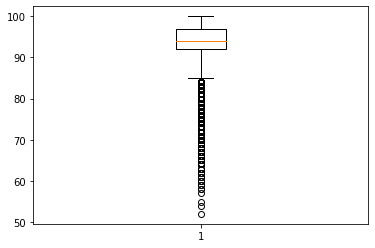

Describe scores data ANOMALIES REMOVED: 
count    201753.000000
mean         94.163185
std           3.233054
min          83.000000
25%          92.000000
50%          94.000000
75%          97.000000
max         100.000000
Name: SCORE, dtype: float64


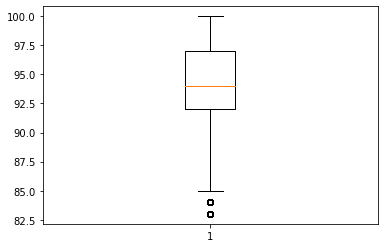

done handleSave
done uploadFrame
testing inspections: 
{'_id': 'INS_DA0004KIJ', 'ACTIVITY DATE': '02/07/2019', 'FACILITY ID': 'FA0067946', 'FACILITY NAME': 'ONE STOP SHOP MART', 'PROGRAM STATUS': 'ACTIVE', 'PE DESCRIPTION': 'FOOD MKT RETAIL (1-1,999 SF) LOW RISK', 'FACILITY ZIP': '90401', 'SCORE': 93.0, 'SERIAL NUMBER': 'DA0004KIJ', 'SEATING DETAILS': '1-1,999 SF'}
inserted into Mongo
done handleLoadToDB
Creating Notebook (Tabs)
     quantity      zip
342  8.333333  90509 -
288  8.285714  90103 -
267  8.200000  90252 -
333  8.000000  91280 -
322  7.750000  90510 -
..        ...      ...
368  0.500000  93021 -
262  0.250000  91109 -
350  0.000000  90053 -
315  0.000000  90407 -
372  0.000000  91763 -

[373 rows x 2 columns]
====> Pearson correlation between number of violations per vendor and their zip code: 
 -0.2624757613191535
    keys  values
3   F044   29789
12  F033   28975
2   F035   26068
17  F040   21578
24  F036   20804
..   ...     ...
51  MF45       1
50  MF41       1
49  MF

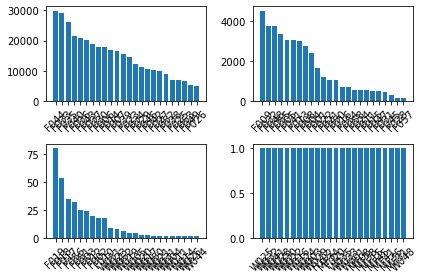

In [161]:
ui = UserInterface('summative')
ui.createWindow()

In [5]:
collection_vendors.count_documents({})

1155993

In [68]:
violationsZipAgg = collection_vendors.aggregate([
    {'$group': {'_id': '$SERIAL NUMBER','PROGRAM STATUS':{'$addToSet':'$PROGRAM STATUS'},'ZIP': {'$addToSet':'$FACILITY ZIP'}, 'VIOLATIONS': {'$addToSet': '$VIOLATION CODE'}}}
])
# Create dict with {zip code: [violations no. per facility]}
vioDict = {}
zipList = []
quantList = []
for item in violationsZipAgg:
    try:
        if item['PROGRAM STATUS'][0] == 'INACTIVE':
            continue
    except:
        print(f'No program status: {item}')
    try:
        zipList.append(int(item['ZIP'][0]))
        quantList.append(len(item['VIOLATIONS']))
        zipCode = int(item['ZIP'][0])
        if zipCode in vioDict:
            vioDict[zipCode].append(len(item['VIOLATIONS']))
        else:
            vioDict[zipCode] = [len(item['VIOLATIONS'])]
    # Possible error - some violations have serial numbers that are not recorded in Inspections data.
    # These are not used in plots because they do not correspond to a facility.
    except Exception as e:
        print(f'Error: "{e}". Cannot add this item to dictionary: {item["_id"]}')

# Calc mean for violation no.
for v in vioDict:
    tempSeries = pd.Series(vioDict[v])
    mean = tempSeries.mean()
    vioDict[v] = mean

#  Create DataFrame - sorted by zip to make visualisations easier to understand
data = {
    'quantity': list(vioDict.values()),
    'zip': list(vioDict.keys())
}
insViosDF = pd.DataFrame(data)
insViosDF.sort_values(by=['quantity'],ascending=False,inplace=True)
print(insViosDF)

No program status: {'_id': 'DADE1PSRL', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F038', 'F007', 'F005', 'F052', 'F043', 'F040', 'F001', 'F048', 'F037', 'F044', 'F039', 'F034', 'F045', 'F006', 'F033']}
Error: "list index out of range". Cannot add this item to dictionary: DADE1PSRL
No program status: {'_id': 'DAQOAUGWK', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F035', 'F033', 'F007', 'F039', 'F034', 'F054', 'F044', 'F014', 'F001']}
Error: "list index out of range". Cannot add this item to dictionary: DAQOAUGWK
No program status: {'_id': 'DAXYRSA4K', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F023', 'F054', 'F011', 'F007', 'F040', 'F033', 'F005', 'F044']}
Error: "list index out of range". Cannot add this item to dictionary: DAXYRSA4K
No program status: {'_id': 'DA20QBXPV', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F041', 'F033', 'F036', 'F027', 'F043', 'F037', 'F044', 'F030', 'F029', 'F023', 'F014', 'F034', 'F004']}
Error: "list index out of range". Cannot add

No program status: {'_id': 'DAFKOC8SP', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F050', 'F044', 'F049', 'F033', 'F013', 'F036', 'F052', 'F023']}
Error: "list index out of range". Cannot add this item to dictionary: DAFKOC8SP
No program status: {'_id': 'DA35EP4EY', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F035', 'F013', 'F006', 'F032', 'F044', 'F023', 'F052', 'F043', 'F014', 'F040', 'F033']}
Error: "list index out of range". Cannot add this item to dictionary: DA35EP4EY
No program status: {'_id': 'DARWJHJUF', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F007', 'F014', 'F048', 'F036', 'F015', 'F037', 'F044', 'F013', 'F009', 'F001', 'F049', 'F035', 'F052', 'F046', 'F025']}
Error: "list index out of range". Cannot add this item to dictionary: DARWJHJUF
No program status: {'_id': 'DAWWVU6KE', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F023', 'F055', 'F050', 'F049', 'F035', 'F007', 'F033', 'F014', 'F013', 'F044']}
Error: "list index out of range". Cannot add this it

No program status: {'_id': 'DAFWORA5S', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F009', 'F050', 'F007', 'F027', 'F036', 'F044', 'F023']}
Error: "list index out of range". Cannot add this item to dictionary: DAFWORA5S
No program status: {'_id': 'DALLN7P2S', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F033', 'F014', 'F043', 'F023', 'F044', 'F050', 'F035', 'F040']}
Error: "list index out of range". Cannot add this item to dictionary: DALLN7P2S
No program status: {'_id': 'DAI4N05JE', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F023', 'F044', 'F009', 'F033', 'F027', 'F035', 'F007', 'F050']}
Error: "list index out of range". Cannot add this item to dictionary: DAI4N05JE
No program status: {'_id': 'DAGUVHBTO', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F040', 'F014', 'F036', 'F029', 'F037', 'F044', 'F034', 'F006', 'F038', 'F033', 'F007', 'F042', 'F046', 'F030', 'F023', 'F049', 'F035']}
Error: "list index out of range". Cannot add this item to dictionary: DAGUVHBTO
No p

No program status: {'_id': 'DA95W392X', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F033', 'F027', 'F007', 'F055', 'F039', 'F013', 'F036', 'F032', 'F014', 'F040', 'F035', 'F049', 'F026', 'F054', 'F023', 'F030', 'F043']}
Error: "list index out of range". Cannot add this item to dictionary: DA95W392X
No program status: {'_id': 'DAVPCMMAI', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F049', 'F036', 'F014', 'F008', 'F005', 'F044', 'F046', 'F043', 'F004', 'F040', 'F033', 'F035']}
Error: "list index out of range". Cannot add this item to dictionary: DAVPCMMAI
No program status: {'_id': 'DA15QWCFP', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F006', 'F048', 'F014', 'F041', 'F023', 'F044', 'F052', 'F043', 'F029', 'F055', 'F025', 'F033', 'F035']}
Error: "list index out of range". Cannot add this item to dictionary: DA15QWCFP
No program status: {'_id': 'DARMBLFDO', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F014', 'F033', 'F035', 'F054', 'F055', 'F044', 'F023', 'F037', 'F036

No program status: {'_id': 'DAOFMH8RO', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F033', 'F027', 'F052', 'F046', 'F030', 'F035', 'F040', 'F014', 'F036', 'F037', 'F044', 'F039', 'F004', 'F007']}
Error: "list index out of range". Cannot add this item to dictionary: DAOFMH8RO
No program status: {'_id': 'DACYPMRMQ', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F049', 'F006', 'F007', 'F026', 'F054', 'F037', 'F009', 'F023', 'F014']}
Error: "list index out of range". Cannot add this item to dictionary: DACYPMRMQ
No program status: {'_id': 'DATJOBPBB', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F033', 'F007', 'F009', 'F052', 'F023', 'F044', 'F054', 'F035', 'F049', 'F040']}
Error: "list index out of range". Cannot add this item to dictionary: DATJOBPBB
No program status: {'_id': 'DA9MNKWFA', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F049', 'F035', 'F048', 'F052', 'F043', 'F023', 'F006', 'F038', 'F033', 'F027', 'F007', 'F037', 'F044', 'F032', 'F036']}
Error: "list index o

No program status: {'_id': 'DAIPJ9QZK', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F033', 'F027', 'F006', 'F039', 'F044', 'F024', 'F029', 'F001', 'F036', 'F040', 'F035', 'F026', 'F030', 'F046', 'F043', 'F025']}
Error: "list index out of range". Cannot add this item to dictionary: DAIPJ9QZK
No program status: {'_id': 'DAVIB6V0C', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F040', 'F035', 'F030', 'F043', 'F005', 'F038', 'F033', 'F027', 'F006', 'F034', 'F039', 'F044', 'F029', 'F037', 'F036']}
Error: "list index out of range". Cannot add this item to dictionary: DAVIB6V0C
No program status: {'_id': 'DA8IKSLG7', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F048', 'F035', 'F040', 'F008', 'F007', 'F054', 'F046', 'F043', 'F044', 'F014']}
Error: "list index out of range". Cannot add this item to dictionary: DA8IKSLG7
No program status: {'_id': 'DADAQFOVI', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F007', 'F040', 'F027', 'F035', 'F054', 'F006', 'F044', 'F023', 'F043', 'F037

Error: "list index out of range". Cannot add this item to dictionary: DAAXWJWAV
No program status: {'_id': 'DAFTUSOUF', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F050', 'F044', 'F026', 'F006', 'F040', 'F014', 'F036', 'F043', 'F023']}
Error: "list index out of range". Cannot add this item to dictionary: DAFTUSOUF
No program status: {'_id': 'DAK6AHJU3', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F054', 'F007', 'F040', 'F033', 'F035', 'F005', 'F014', 'F044', 'F030']}
Error: "list index out of range". Cannot add this item to dictionary: DAK6AHJU3
No program status: {'_id': 'DAF2AA3PG', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F052', 'F046', 'F023', 'F053', 'F035', 'F040', 'F050', 'F044', 'F022', 'F048', 'F021', 'F006', 'F038', 'F033']}
Error: "list index out of range". Cannot add this item to dictionary: DAF2AA3PG
No program status: {'_id': 'DATKX0X2K', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F037', 'F050', 'F027', 'F006', 'F053', 'F036', 'F014', 'F044', 'F023

Error: "list index out of range". Cannot add this item to dictionary: DAUKMFE4P
No program status: {'_id': 'DA6ZHLMCT', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F042', 'F005', 'F007', 'F033', 'F039', 'F037', 'F044', 'F036', 'F013', 'F035', 'F040', 'F030', 'F023', 'F053']}
Error: "list index out of range". Cannot add this item to dictionary: DA6ZHLMCT
No program status: {'_id': 'DA9KUFZI0', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F044', 'F039', 'F054', 'F004', 'F049', 'F011', 'F007', 'F014', 'F036']}
Error: "list index out of range". Cannot add this item to dictionary: DA9KUFZI0
No program status: {'_id': 'DAXIMMBP0', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F052', 'F043', 'F055', 'F039', 'F034', 'F033', 'F025', 'F006', 'F048', 'F036', 'F014', 'F044', 'F037', 'F035', 'F042', 'F023', 'F046']}
Error: "list index out of range". Cannot add this item to dictionary: DAXIMMBP0
No program status: {'_id': 'DAVDZ2X75', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F052

No program status: {'_id': 'DACZ5ZJ1H', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F054', 'F049', 'F007', 'F014', 'F013', 'F029', 'F037', 'F044']}
Error: "list index out of range". Cannot add this item to dictionary: DACZ5ZJ1H
No program status: {'_id': 'DAJI46X0P', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F037', 'F023', 'F044', 'F006', 'F040', 'F033', 'F050', 'F027']}
Error: "list index out of range". Cannot add this item to dictionary: DAJI46X0P
No program status: {'_id': 'DA0FCPOAR', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F053', 'F035', 'F022', 'F032', 'F044', 'F001', 'F029', 'F009', 'F034', 'F007', 'F006']}
Error: "list index out of range". Cannot add this item to dictionary: DA0FCPOAR
No program status: {'_id': 'DA8SAXVF2', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F044', 'F029', 'F037', 'F014', 'F038', 'F033', 'F007', 'F006', 'F039', 'F023', 'F043', 'F046', 'F040', 'F035']}
Error: "list index out of range". Cannot add this item to dictionary: DA8SAX

No program status: {'_id': 'DASWTUVZX', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F037', 'F009', 'F040', 'F049', 'F035', 'F008', 'F042', 'F047', 'F030', 'F043', 'F004', 'F039', 'F038', 'F033', 'F027', 'F007', 'F036', 'F041', 'F058', 'F014', 'F029']}
Error: "list index out of range". Cannot add this item to dictionary: DASWTUVZX
No program status: {'_id': 'DA1WFGRBW', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F052', 'F043', 'F050', 'F040', 'F033', 'F006', 'F053', 'F014', 'F023', 'F044']}
Error: "list index out of range". Cannot add this item to dictionary: DA1WFGRBW
No program status: {'_id': 'DATMFG8PZ', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F042', 'F035', 'F038', 'F040', 'F014', 'F006', 'F043', 'F025', 'F044', 'F030', 'F041', 'F023', 'F036']}
Error: "list index out of range". Cannot add this item to dictionary: DATMFG8PZ
No program status: {'_id': 'DAFA9REUE', 'PROGRAM STATUS': [], 'ZIP': [], 'VIOLATIONS': ['F033', 'F038', 'F035', 'F049', 'F027', 'F007', 'F050

In [49]:
insViosDF.quantity

351    8.333333
249    8.285714
284    8.200000
335    8.000000
325    7.750000
         ...   
371    0.500000
280    0.250000
342    0.000000
301    0.000000
372    0.000000
Name: quantity, Length: 373, dtype: float64

In [19]:
vioDict

{90066: 4.007832898172324,
 91205: 5.082219938335046,
 90220: 4.20631970260223,
 91504: 3.4946004319654427,
 90280: 3.3253493013972055,
 91006: 4.016248153618907,
 90016: 3.952076677316294,
 90014: 4.195364238410596,
 91706: 3.864,
 91016: 3.804222648752399,
 90036: 4.551566579634465,
 90057: 5.0412517780938835,
 90703: 4.717735220649459,
 91342: 4.869623655913978,
 90046: 5.119162640901771,
 90012: 4.612756264236902,
 90401: 3.542654028436019,
 91789: 4.272851296043656,
 91602: 4.7272727272727275,
 91210: 4.555900621118012,
 91356: 4.2034682080924854,
 91321: 3.1291338582677164,
 90039: 4.601926163723917,
 90022: 5.089193825042882,
 90043: 5.159883720930233,
 90028: 4.092502434274587,
 91605: 5.121244635193133,
 91203: 4.895008605851979,
 91352: 4.791338582677166,
 90001: 4.92170818505338,
 90029: 4.613070539419087,
 91748: 5.379375,
 91343: 5.523489932885906,
 90250: 4.675122749590835,
 90034: 4.829015544041451,
 91502: 3.3318056828597618,
 91331: 4.8561776061776065,
 91731: 4.658322

In [44]:
insViosDF.sort_values(by=['zip'],inplace=True)
insViosDF['quantity'].corr(insViosDF['zip'])

-0.26247576131915357

In [79]:
insViosDF

,quantity,zip
351,8.333333,90509
249,8.285714,90103
284,8.200000,90252
335,8.000000,91280
325,7.750000,90510
...,...,...
371,0.500000,90295
280,0.250000,91109
342,0.000000,90053
301,0.000000,90407


In [46]:
insViosDF['zip'] = str(insViosDF['zip'])

In [47]:
insViosDF['zip']

29     29     90001\n82     90002\n96     90003\n172 ...
82     29     90001\n82     90002\n96     90003\n172 ...
96     29     90001\n82     90002\n96     90003\n172 ...
172    29     90001\n82     90002\n96     90003\n172 ...
55     29     90001\n82     90002\n96     90003\n172 ...
                             ...                        
217    29     90001\n82     90002\n96     90003\n172 ...
51     29     90001\n82     90002\n96     90003\n172 ...
182    29     90001\n82     90002\n96     90003\n172 ...
288    29     90001\n82     90002\n96     90003\n172 ...
201    29     90001\n82     90002\n96     90003\n172 ...
Name: zip, Length: 373, dtype: object

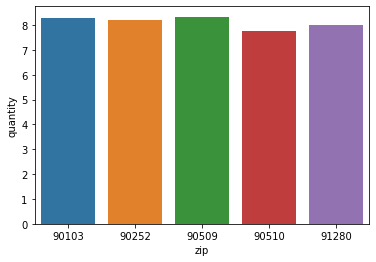

In [67]:
# figure = Figure(figsize=(8, 40))
# ax = figure.subplots()
sns.barplot(x="zip", y="quantity", data=insViosDF.head())
plt.show()

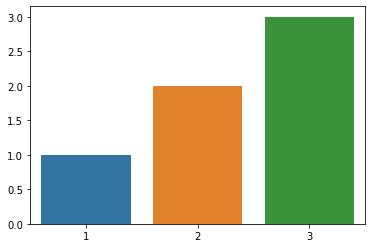

In [56]:
sns.barplot(x=[1,2,3], y=[1,2,3])
plt.show()

In [66]:
insViosDF

,quantity,zip
351,8.333333,90509
249,8.285714,90103
284,8.200000,90252
335,8.000000,91280
325,7.750000,90510
...,...,...
371,0.500000,90295
280,0.250000,91109
342,0.000000,90053
301,0.000000,90407


In [73]:
data = {'zip': zipList, 'quantity': quantList}
df = pd.DataFrame(data)
df

,zip,quantity
0,90066,6
1,91205,6
2,90220,3
3,91504,7
4,90280,1
...,...,...
180168,90248,5
180169,90245,5
180170,90036,7
180171,91791,2


In [74]:
df['quantity'].corr(df['zip'])

-0.07733504306355668

In [76]:
len(zipList)

180173

In [77]:
zipSet = set(zipList)
len(zipSet)

373

In [78]:
zipSet

{90001,
 90002,
 90003,
 90004,
 90005,
 90006,
 90007,
 90008,
 90010,
 90011,
 90012,
 90013,
 90014,
 90015,
 90016,
 90017,
 90018,
 90019,
 90020,
 90021,
 90022,
 90023,
 90024,
 90025,
 90026,
 90027,
 90028,
 90029,
 90030,
 90031,
 90032,
 90033,
 90034,
 90035,
 90036,
 90037,
 90038,
 90039,
 90040,
 90041,
 90042,
 90043,
 90044,
 90045,
 90046,
 90047,
 90048,
 90049,
 90051,
 90053,
 90054,
 90056,
 90057,
 90058,
 90059,
 90061,
 90062,
 90063,
 90064,
 90065,
 90066,
 90067,
 90068,
 90069,
 90070,
 90071,
 90077,
 90079,
 90086,
 90089,
 90094,
 90095,
 90103,
 90123,
 90201,
 90207,
 90210,
 90211,
 90212,
 90214,
 90220,
 90221,
 90222,
 90225,
 90230,
 90231,
 90232,
 90233,
 90240,
 90241,
 90242,
 90245,
 90247,
 90248,
 90249,
 90250,
 90252,
 90253,
 90254,
 90255,
 90260,
 90262,
 90263,
 90265,
 90266,
 90270,
 90272,
 90274,
 90275,
 90277,
 90278,
 90280,
 90286,
 90290,
 90291,
 90292,
 90293,
 90295,
 90296,
 90301,
 90302,
 90303,
 90304,
 90305,
 90353,


In [81]:
insViosDF['new'] = insViosDF['zip'].apply(str) + ' -'

In [82]:
insViosDF

,quantity,zip,new
351,8.333333,90509,90509 -
249,8.285714,90103,90103 -
284,8.200000,90252,90252 -
335,8.000000,91280,91280 -
325,7.750000,90510,90510 -
...,...,...,...
371,0.500000,90295,90295 -
280,0.250000,91109,91109 -
342,0.000000,90053,90053 -
301,0.000000,90407,90407 -


In [89]:
insViosDF['new'] = insViosDF['new'].str.replace(' -', '')
insViosDF['new'] = insViosDF['new'].apply(int)

In [91]:
insViosDF['new'].apply(int)

351    90509
249    90103
284    90252
335    91280
325    90510
       ...  
371    90295
280    91109
342    90053
301    90407
372    91763
Name: new, Length: 373, dtype: int64